# Assignment 1
### Martynas Vaznonis 2701013

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from math import e, log
from random import normalvariate
from tqdm import tqdm
from data import load_synth, load_mnist

## Scalar Backpropagation

In [2]:
def sigmoid(x):
    return 1/(1+e**-x)

def softmax(x):
    x = [e**o for o in x]
    E = sum(x)
    return [o/E for o in x]


class ScalarFCN:
    def __init__(self, lr=1e-4):
        self.lr = lr
        self.W = [[normalvariate() for _ in range(3)] for _ in range(2)]
        self.V = [[normalvariate() for _ in range(2)] for _ in range(3)]
        # self.W = [[1] * 3, [-1] * 3]
        # self.V = [[1, 1], [-1, -1], [-1, -1]]
        self.b = [0, 0, 0]
        self.c = [0, 0]
        self.losses = list()

    @staticmethod
    def next_layer(I, W, B, func=lambda x:x):
        o = [0] * len(B)
        for inp, ws in zip(I, W):
            for i, w in enumerate(ws):
                o[i] += w * inp
        for i in range(len(o)):
            o[i] = func(o[i] + B[i])
        return o
    
    def classify(self, x):
        return np.argmax(softmax(self.next_layer(self.next_layer(x, self.W, self.b, func=sigmoid), self.V, self.c)))

    def forward(self, x, y):
        self.data, self.target = x, y
        self.h = self.next_layer(x, self.W, self.b, func=sigmoid)
        self.y = softmax(self.next_layer(self.h, self.V, self.c))
        self.losses.append(-log(self.y[y]))

    def backward(self):
        # Find derivatives
        dloss = -1/self.y[self.target]
        do = [dloss * self.y[i] * ((i == self.target) - self.y[self.target])
              for i in range(len(self.y))]
        dV = [[o * h for o in do] for h in self.h]
        
        dh = [sum([o * v for o, v in zip(do, V)]) for V in self.V]
        dh = [d * h * (1 - h) for d, h in zip(dh, self.h)]
        dW = [[i * h for h in dh] for i in self.data]
        
        # Update weights
        for j in range(len(self.V[0])):
            for i in range(len(self.V)):
                self.V[i][j] -= self.lr * dV[i][j]
            self.c[j] -= self.lr * do[j]
        
        for j in range(len(self.W[0])):
            for i in range(len(self.W)):
                self.W[i][j] -= self.lr * dW[i][j]
            self.b[j] -= self.lr * dh[j]


In [3]:
(xtrain, ytrain), (xval, yval), num_cls = load_synth()
t = np.concatenate([xtrain, xval])
min, max = t.min(axis=0), t.max(axis=0)
xtrain -= min
xtrain /= max - min
xval -= min
xval /= max - min

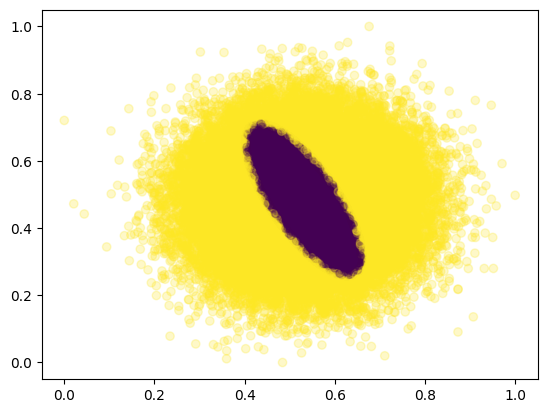

In [4]:
plt.scatter(*xtrain.T, c=ytrain, alpha=0.25)
plt.show()

In [5]:
fcn = ScalarFCN(lr=1e-1)
EPOCHS = 3
for i in range(EPOCHS):
    print(f"Epoch {i+1}/{EPOCHS}")
    ind = np.random.permutation(range(len(xtrain)))
    for x, y in tqdm(zip(xtrain[ind], ytrain[ind])):
        fcn.forward(x, y)
        fcn.backward()

fcn.lr = 1e-2
ind = np.random.permutation(range(len(xtrain)))
for x, y in tqdm(zip(xtrain[ind], ytrain[ind])):
    fcn.forward(x, y)
    fcn.backward()

Epoch 1/3


60000it [00:01, 36014.43it/s]


Epoch 2/3


60000it [00:01, 35596.84it/s]


Epoch 3/3


60000it [00:01, 36640.41it/s]
60000it [00:01, 36253.74it/s]


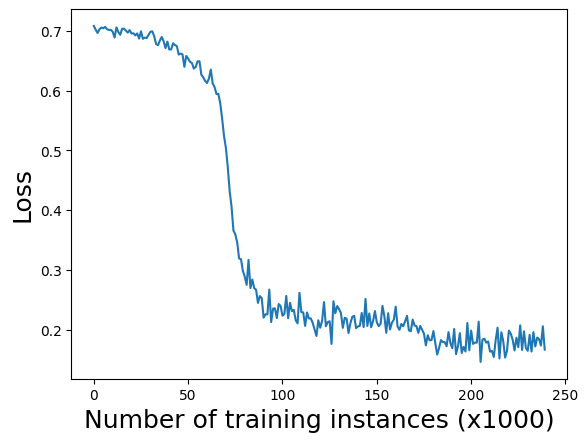

In [6]:
red = 1000

plt.plot([sum(fcn.losses[i:i+red])/len(fcn.losses[i:i+red]) for i in range(0, len(fcn.losses), red)])
plt.ylabel("Loss", fontsize=18)
plt.xlabel(f"Number of training instances (x{red})", fontsize=18)
plt.savefig('images/loss1.png')
plt.show()

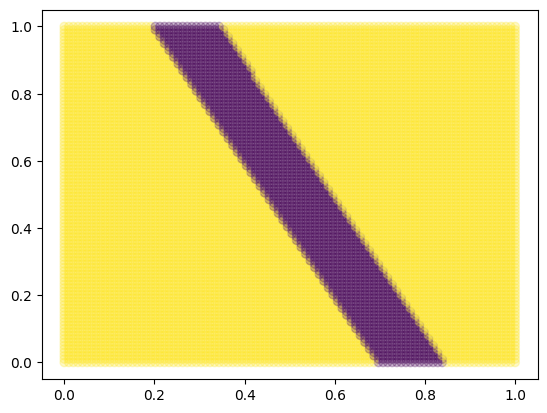

In [7]:
xv, yv = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(xv.flatten(), yv.flatten(), c=list(map(lambda x: fcn.classify(x), zip(xv.flatten(), yv.flatten()))), alpha=0.25)
plt.savefig("images/synlearned.png")
plt.show()

## Tensor Backpropagation

### Question 5

In [8]:
(xtrain, ytrain), (xval, yval), num_cls = load_mnist()
xtrain, xval = xtrain / 255, xval / 255

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    x = np.exp(x)
    return x/sum(x)

class VectorFCN:
    def __init__(self, input_size=784, hidden_size=300, output_size=10, lr=1e-3):
        self.lr = lr
        self.W = np.random.randn(hidden_size, input_size)
        self.b = np.zeros(hidden_size)
        self.V = np.random.randn(output_size, hidden_size)
        self.c = np.zeros(output_size)
        self.losses = list()
    
    def classify(self, x):
        return np.argmax(softmax(self.V @ sigmoid(self.W @ x + self.b) + self.c))

    def forward(self, inp, target):
        self.data, self.target = inp, target
        self.h = sigmoid(self.W @ inp + self.b)
        self.y = softmax(self.V @ self.h + self.c)
        self.losses.append(-np.log(self.y[target]))

    def backward(self):
        dloss = -1/self.y[self.target]
        do = dloss * self.y * ((np.arange(10) == self.target) - self.y[self.target])
        self.c -= self.lr * do
        
        dV = do.reshape(-1, 1) @ self.h.reshape(1, -1)
        self.V -= self.lr * dV
        
        dh = do @ self.V * self.h * (1 - self.h)
        self.b -= self.lr * dh
        
        dW = dh.reshape(-1, 1) @ self.data.reshape(1, -1)
        self.W -= self.lr * dW

In [10]:
fcn = VectorFCN()
EPOCHS = 3
for i in range(EPOCHS):
    print(f"Epoch {i + 1}/{EPOCHS}")
    ind = np.random.permutation(range(len(xtrain)))
    for x, y in tqdm(zip(xtrain[ind], ytrain[ind])):
        fcn.forward(x, y)
        fcn.backward()

Epoch 1/3


55000it [01:45, 518.96it/s]


Epoch 2/3


55000it [01:50, 499.25it/s]


Epoch 3/3


55000it [01:57, 466.51it/s]


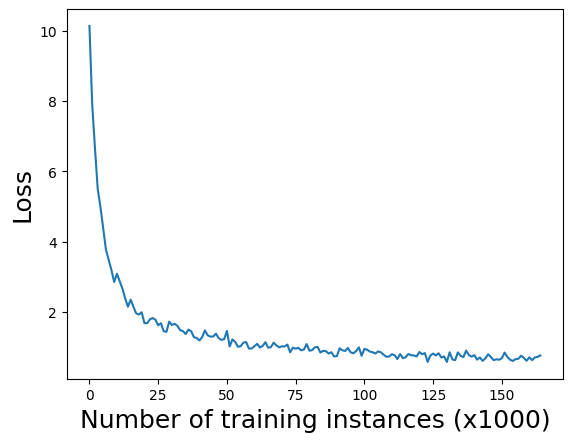

In [11]:
plt.plot([sum(fcn.losses[i:i+red])/len(fcn.losses[i:i+red]) for i in range(0, len(fcn.losses), red)])
plt.ylabel("Loss", fontsize=18)
plt.xlabel(f"Number of training instances (x{red})", fontsize=18)
plt.savefig('images/loss2.png')
plt.show()

In [12]:
pred = np.asarray([fcn.classify(x) for x in xval])
(pred == yval).mean()

0.877

### Question 6

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    x = np.exp(x)
    return x/np.expand_dims(x.sum(axis=1), -1)

class VectorFCN:
    def __init__(self, input_size=784, hidden_size=300, output_size=10, lr=1e-3):
        self.lr = lr
        self.W = np.random.randn(hidden_size, input_size)
        self.b = np.zeros((hidden_size, 1))
        self.V = np.random.randn(output_size, hidden_size)
        self.c = np.zeros((output_size, 1))
        self.input_size = input_size
        self.num_classes = output_size
        self.losses = list()
    
    def classify(self, x):
        return softmax(self.V @ sigmoid(self.W @ x.reshape(-1, self.input_size, 1) + self.b) +
                       self.c).reshape(-1, self.num_classes).argmax(axis=1)
    
    def loss(self, x, y):
        return -np.log(softmax(self.V @ sigmoid(self.W @ x.reshape(-1, self.input_size, 1) + self.b) +
                       self.c).reshape(-1, self.num_classes)[np.arange(len(x)), y])

    def forward(self, inp, target):
        self.data, self.target = inp.reshape(-1, self.input_size, 1), target
        self.h = sigmoid(self.W @ self.data + self.b)
        self.y = softmax(self.V @ self.h + self.c)
        self.losses.append(-np.log(self.y[range(len(self.y)), target]).mean())

    def backward(self):
        dloss = -1/self.y[range(len(self.y)), self.target]
        do = np.expand_dims(dloss, 1) * self.y * (
            (np.tile(range(10), (len(self.y), 1)) == self.target.reshape(-1, 1)) -
            self.y[range(len(self.y)), self.target]
        ).reshape(-1, 10, 1)
        self.c -= self.lr * do.mean(axis=0)
        
        dV = do @ self.h.swapaxes(1, -1)
        self.V -= self.lr * dV.mean(axis=0)
        
        dh = self.V.T @ do * self.h * (1 - self.h)
        self.b -= self.lr * dh.mean(axis=0)
        
        dW = dh @ self.data.swapaxes(1, -1)
        self.W -= self.lr * dW.mean(axis=0)

In [14]:
fcn = VectorFCN()
EPOCHS = 3
batch_size = 16
for i in range(EPOCHS):
    print(f"Epoch {i + 1}/{EPOCHS}")
    ind = np.random.permutation(range(len(xtrain)))
    xtrain, ytrain = xtrain[ind], ytrain[ind]
    for j in tqdm(range(0, len(xtrain), batch_size)):
        fcn.forward(xtrain[j:j+batch_size], ytrain[j:j+batch_size])
        fcn.backward()

Epoch 1/3


100%|██████████████████████████████████████████████████████████████████████████████| 3438/3438 [01:15<00:00, 45.81it/s]


Epoch 2/3


100%|██████████████████████████████████████████████████████████████████████████████| 3438/3438 [01:14<00:00, 45.87it/s]


Epoch 3/3


100%|██████████████████████████████████████████████████████████████████████████████| 3438/3438 [01:15<00:00, 45.72it/s]


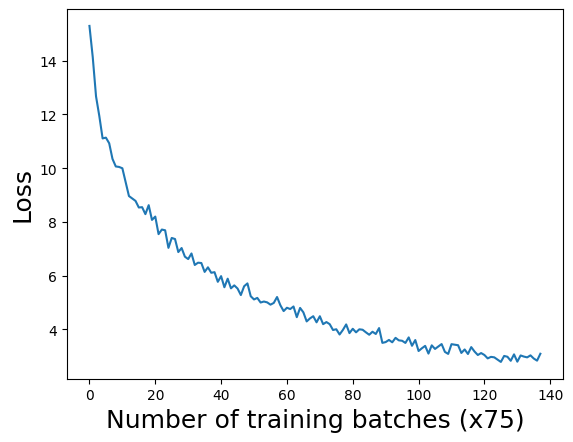

In [15]:
red = 75

plt.plot([sum(fcn.losses[i:i+red])/len(fcn.losses[i:i+red]) for i in range(0, len(fcn.losses), red)])
plt.ylabel("Loss", fontsize=18)
plt.xlabel(f"Number of training batches (x{red})", fontsize=18)
plt.savefig('images/loss3.png')
plt.show()

In [16]:
pred = fcn.classify(xval)
(pred == yval).mean()

0.5758

### Question 7

#### 1

In [17]:
fcn = VectorFCN()
EPOCHS = 5
batch_size = 8
ltrain, lval = list(), list()
for i in range(EPOCHS):
    print(f"Epoch {i + 1}/{EPOCHS}")
    ind = np.random.permutation(range(len(xtrain)))
    xtrain, ytrain = xtrain[ind], ytrain[ind]
    for j in tqdm(range(0, len(xtrain), batch_size)):
        fcn.forward(xtrain[j:j+batch_size], ytrain[j:j+batch_size])
        fcn.backward()
    ltrain.append(fcn.losses)
    fcn.losses = list()
    lval.append(fcn.loss(xval, yval))

Epoch 1/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:19<00:00, 86.34it/s]


Epoch 2/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.12it/s]


Epoch 3/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:17<00:00, 88.53it/s]


Epoch 4/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.64it/s]


Epoch 5/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:17<00:00, 88.85it/s]


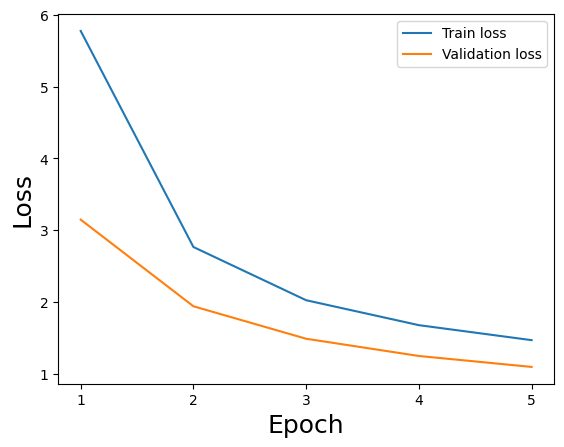

In [18]:
plt.plot(range(1, 6), [sum(l)/len(l) for l in ltrain], label="Train loss")
plt.plot(range(1, 6), [sum(l)/len(l) for l in lval], label="Validation loss")
plt.xticks(range(1, 6))
plt.ylabel("Loss", fontsize=18)
plt.xlabel("Epoch", fontsize=18)
plt.legend()
plt.savefig("images/Validation")
plt.show()

In [19]:
(fcn.classify(xval) == yval).mean()

0.7712

#### 2

In [20]:
losses = list()
for _ in range(3):
    fcn = VectorFCN()
    for i in range(EPOCHS):
        print(f"Epoch {i + 1}/{EPOCHS}")
        ind = np.random.permutation(range(len(xtrain)))
        xtrain, ytrain = xtrain[ind], ytrain[ind]
        for j in tqdm(range(0, len(xtrain), batch_size)):
            fcn.forward(xtrain[j:j+batch_size], ytrain[j:j+batch_size])
            fcn.backward()
    losses.append(fcn.losses)

Epoch 1/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.33it/s]


Epoch 2/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:18<00:00, 87.85it/s]


Epoch 3/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.46it/s]


Epoch 4/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:18<00:00, 87.75it/s]


Epoch 5/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.32it/s]


Epoch 1/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:18<00:00, 87.77it/s]


Epoch 2/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.24it/s]


Epoch 3/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:17<00:00, 88.36it/s]


Epoch 4/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:21<00:00, 84.45it/s]


Epoch 5/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:15<00:00, 91.03it/s]


Epoch 1/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:17<00:00, 89.20it/s]


Epoch 2/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:17<00:00, 88.81it/s]


Epoch 3/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:14<00:00, 92.17it/s]


Epoch 4/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:18<00:00, 87.73it/s]


Epoch 5/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:18<00:00, 87.05it/s]


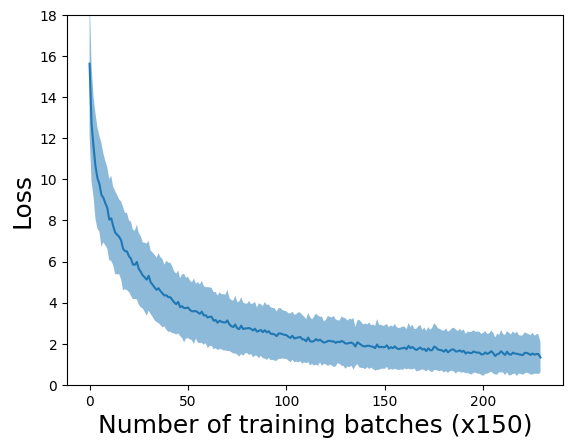

In [21]:
red = 150

df = pd.DataFrame(losses).T
mean = df.groupby(df.index // red).mean().mean(axis=1)
std = df.std(axis=1).groupby(df.index // red).mean()
plt.plot(mean)
plt.fill_between(range(len(mean)), mean + std, mean - std, alpha=0.5)
plt.ylabel("Loss", fontsize=18)
plt.xlabel(f"Number of training batches (x{red})", fontsize=18)
plt.ylim(0, 18)
plt.savefig('images/average.png')
plt.show()

#### 3

In [22]:
losses = dict()
for lr in [0.001, 0.003, 0.01, 0.03]:
    fcn = VectorFCN(lr=lr)
    for i in range(EPOCHS):
        print(f"Epoch {i + 1}/{EPOCHS}")
        ind = np.random.permutation(range(len(xtrain)))
        xtrain, ytrain = xtrain[ind], ytrain[ind]
        for j in tqdm(range(0, len(xtrain), batch_size)):
            fcn.forward(xtrain[j:j+batch_size], ytrain[j:j+batch_size])
            fcn.backward()
    losses[lr] = fcn.losses

Epoch 1/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:18<00:00, 87.42it/s]


Epoch 2/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:14<00:00, 92.72it/s]


Epoch 3/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:22<00:00, 83.77it/s]


Epoch 4/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:12<00:00, 95.19it/s]


Epoch 5/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.63it/s]


Epoch 1/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:17<00:00, 88.83it/s]


Epoch 2/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.75it/s]


Epoch 3/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:17<00:00, 88.18it/s]


Epoch 4/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.43it/s]


Epoch 5/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:17<00:00, 89.09it/s]


Epoch 1/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.66it/s]


Epoch 2/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:18<00:00, 87.18it/s]


Epoch 3/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.45it/s]


Epoch 4/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:17<00:00, 88.42it/s]


Epoch 5/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:19<00:00, 86.99it/s]


Epoch 1/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:15<00:00, 90.86it/s]


Epoch 2/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.74it/s]


Epoch 3/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:16<00:00, 89.80it/s]


Epoch 4/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:24<00:00, 81.11it/s]


Epoch 5/5


100%|██████████████████████████████████████████████████████████████████████████████| 6875/6875 [01:17<00:00, 88.92it/s]


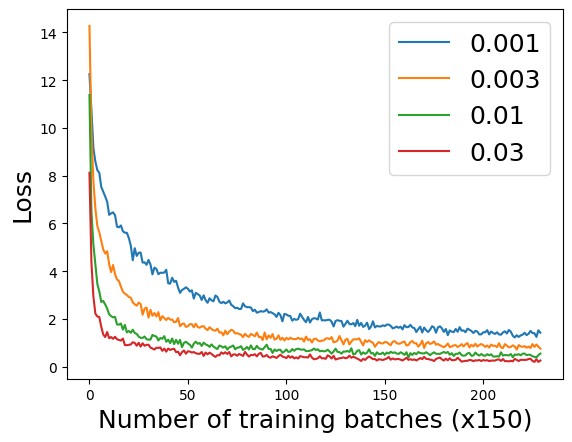

In [23]:
df = pd.DataFrame(losses)
mean = df.groupby(df.index // red).mean()
mean.plot()
plt.ylabel("Loss", fontsize=18)
plt.xlabel(f"Number of training batches (x{red})", fontsize=18)
plt.legend(fontsize=18)
plt.savefig('images/lr.png')
plt.show()

#### 4

In [24]:
(xtrain, ytrain), (xval, yval), num_cls = load_mnist(final=True)
xtrain, xval = xtrain / 255, xval / 255

In [25]:
losses = list()
for _ in range(3):
    fcn = VectorFCN(lr=0.03)
    for i in range(EPOCHS):
        print(f"Epoch {i + 1}/{EPOCHS}")
        ind = np.random.permutation(range(len(xtrain)))
        xtrain, ytrain = xtrain[ind], ytrain[ind]
        for j in tqdm(range(0, len(xtrain), batch_size)):
            fcn.forward(xtrain[j:j+batch_size], ytrain[j:j+batch_size])
            fcn.backward()
    losses.append(fcn.losses)

Epoch 1/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:31<00:00, 81.87it/s]


Epoch 2/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:24<00:00, 88.72it/s]


Epoch 3/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:31<00:00, 81.72it/s]


Epoch 4/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:24<00:00, 88.90it/s]


Epoch 5/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:32<00:00, 81.00it/s]


Epoch 1/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:24<00:00, 88.98it/s]


Epoch 2/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:32<00:00, 81.52it/s]


Epoch 3/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:25<00:00, 87.95it/s]


Epoch 4/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:31<00:00, 81.79it/s]


Epoch 5/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:24<00:00, 89.24it/s]


Epoch 1/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:32<00:00, 81.08it/s]


Epoch 2/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:30<00:00, 83.26it/s]


Epoch 3/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:32<00:00, 81.48it/s]


Epoch 4/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:34<00:00, 79.58it/s]


Epoch 5/5


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:31<00:00, 81.66it/s]


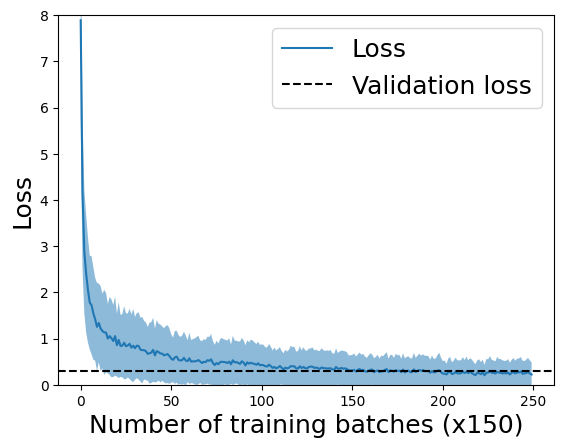

In [26]:
df_final = pd.DataFrame(losses).T
mean = df_final.groupby(df_final.index // red).mean().mean(axis=1)
std = df_final.std(axis=1).groupby(df_final.index // red).mean()
plt.plot(mean, label="Loss")
plt.fill_between(range(len(mean)), mean + std, mean - std, alpha=0.5)
plt.axline((0, fcn.loss(xval, yval).mean()), slope=0, linestyle='--', c='black', label="Validation loss")
plt.ylabel("Loss", fontsize=18)
plt.xlabel(f"Number of training batches (x{red})", fontsize=18)
plt.legend(fontsize=18)
plt.ylim(0, 8)
plt.savefig('images/final.png')
plt.show()

In [27]:
(fcn.classify(xval) == yval).mean()

0.9216